<a href="https://colab.research.google.com/github/sznajdr/bcode/blob/main/barcodezzzcsv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title ▶ + ***liste erstellen & barcodes erstellen***
from IPython.display import clear_output
!wget -nc https://github.com/matomo-org/travis-scripts/raw/71555936095b4d4252ec0a2eeacd710a17793db4/fonts/Arial.ttf
clear_output(wait=True)
import pandas as pd
import ipywidgets as widgets
import json
import requests
import textwrap
import os
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

df = pd.DataFrame(columns=["barcode", "title"])
df = pd.DataFrame(columns=["barcode", "title", "lagerplatz"])  # Added "lagerplatz" column
barcode_textbox = widgets.Text(description="Barcode:")
title_textbox = widgets.Text(description="Titel:")
lagerplatz_textbox = widgets.Text(description="Lagerplatz:")  # Added "lagerplatz" textbox
table = widgets.Output(layout=widgets.Layout(height='84px'))
table.append_display_data(df)

add_button = widgets.Button(description="Hinzufügen", style={'font-size': '20px', 'height': '50px'})
add_barcode_button = widgets.Button(description="Barcodes erstellen", style={'font-size': '20px', 'height': '50px'})

try:
    with open('products.json') as f:
        products = json.load(f)
except FileNotFoundError:
    products = {"products": []}

def add_row(button):
    global df, products
    barcode = barcode_textbox.value
    title = title_textbox.value
    lagerplatz = lagerplatz_textbox.value

    new_row = pd.DataFrame({"barcode": [barcode], "title": [title], "lagerplatz": [lagerplatz]})
    df = pd.concat([df, new_row], ignore_index=True)

    products["products"].append({"barcode": barcode, "title": title, "lagerplatz": lagerplatz})
    table.clear_output()
    with table:
        display(df)
    with open('products.json', 'w') as f:
        json.dump(products, f)

    # Check if the file exists before writing the new row
    file_exists = os.path.isfile('barcodes.csv')
    with open('barcodes.csv', 'a') as f:
        new_row.to_csv(f, index=False, header=not file_exists)


def add_barcode(button):
    global df
    for index, row in df.iterrows():
        barcode = row['barcode']
        title = row['title']
        lagerplatz = row['lagerplatz']
        
        bcid = "ean13"
        font = ImageFont.truetype("Arial.ttf", size=14)
        ean = barcode
        filename = "{}.png".format(barcode)
        url = "https://bwipjs-api.metafloor.com/?bcid={}&text={}".format(bcid, ean)
        response = requests.get(url)
        with open(filename, "wb") as f:
            f.write(response.content)
        filename = filename.strip()
        with Image.open(filename) as img:
            width, height = img.size
            max_title_width = 40
            wrapped_title = textwrap.wrap(title, width=max_title_width, break_long_words=True)
            wrapped_lagerplatz = textwrap.wrap(lagerplatz, width=max_title_width, break_long_words=True)
            wrapped_title_height = 0
            for line in wrapped_title:
                wrapped_title_height += font.getsize(line)[1]
            wrapped_lagerplatz_height = 0
            for line in wrapped_lagerplatz:
                wrapped_lagerplatz_height += font.getsize(line)[1]
            total_width = max(width, font.getsize(title)[0])
            new_width = total_width + 2
            new_height = height + wrapped_title_height + wrapped_lagerplatz_height + 32 + font.getsize(" ")[1]
            new_img = Image.new("RGBA", (new_width, new_height), color=(255, 255, 255, 255))
            barcode_x = (new_width - width) // 2
            new_img.paste(img, (barcode_x, 0), img)
            draw = ImageDraw.Draw(new_img)
            x = new_width // 2
            y = height + 10 + (wrapped_title_height // 2)
            for line in wrapped_title:
                text_width, text_height = font.getsize(line)
                draw.text((x - text_width // 2, y - text_height // 4), line, font=font, fill=(0, 0, 0, 255))
                y += text_height
            y += font.getsize(" ")[1]
            for line in wrapped_lagerplatz:
                text_width, text_height = font.getsize(line)
                draw.text((x - text_width // 2, y - text_height // 4), line, font=font, fill=(0, 0, 0, 255))
                y += text_height

            with table:
                display(new_img)
            # Cut the image in half horizontally and only use the bottom half
            cropped_img = new_img.crop((0, new_height // 2, new_width, new_height))
    
            # Save the final image with the product title as the filename
            final_filename = "/content/" + title + ".png"
            cropped_img.save(final_filename)
            print("Saved final image as:", final_filename)

        df = pd.DataFrame(columns=["barcode", "title", "lagerplatz"])
        table.clear_output()
        with table:
            display(df)

add_button.on_click(add_row)
add_barcode_button.on_click(add_barcode)

gui = widgets.VBox([barcode_textbox, title_textbox, lagerplatz_textbox, add_button, add_barcode_button, table], layout=widgets.Layout(heightd='80px'))  # Added "lagerplatz_textbox" to the GUI
display(gui)

# barcode, title, lagerplatz von barcodes.csv
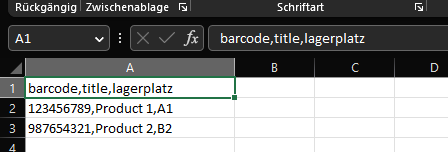

In [10]:
#@title ▶ + ***datei auswählen -> datei uploaden -> barcodes erstellen***
from google.colab import files
from IPython.display import display
import ipywidgets as widgets

upload_button = widgets.FileUpload(description="Datei auswählen")
display(upload_button)

def save_uploaded_file(button):
    uploaded = upload_button.value
    for filename, data in uploaded.items():
        with open("barcodes.csv", "wb") as f:
            f.write(data["content"])
    print("File saved as barcodes.csv")

save_button = widgets.Button(description="upload file")
save_button.on_click(save_uploaded_file)
display(save_button)

def generate_barcodes(button):

# Download Arial.ttf if it doesn't exist
    if not os.path.exists("Arial.ttf"):
      url = "https://github.com/matomo-org/travis-scripts/raw/71555936095b4d4252ec0a2eeacd710a17793db4/fonts/Arial.ttf"
      response = requests.get(url)
      with open("Arial.ttf", "wb") as f:
        f.write(response.content)
    import requests
    import json
    from PIL import Image, ImageDraw, ImageFont
    import csv
    import chardet
    import textwrap

    csv_file = "barcodes.csv"
    json_file = "products.json"

    products = []

    # Determine the character encoding of the CSV file
    with open(csv_file, "rb") as f: 
        result = chardet.detect(f.read())
        encoding = result["encoding"]

    # Open the CSV file with the detected encoding
    with open(csv_file, "r", encoding=encoding) as f:
        reader = csv.DictReader(f)
        for row in reader:
            # Create a new dictionary with the barcode, title, and lagerplatz
            product = {"barcode": row["barcode"], "title": row["title"], "lagerplatz": row["lagerplatz"]}
            # Add the product to the list of products
            products.append(product)

    # Create a dictionary with the products list
    data = {"products": products}

    # Write the dictionary to a JSON file
    with open(json_file, "w") as f:
        json.dump(data, f)


    # Set the barcode type to EAN13
    bcid = "ean13"

    # Set the font for the product titles and lagerplatz
    font = ImageFont.truetype("Arial.ttf", size=14)

    # Load the list of products from the JSON file
    with open("products.json") as f:
        products = json.load(f)["products"]

    # Loop through each product and generate a barcode image
    for product in products:
        # Set the EAN13 number as the text to encode
        ean = product["barcode"]
        # Set the product title as the filename
        filename = "{}.png".format(product["title"])

        # Set the API endpoint URL
        url = "https://bwipjs-api.metafloor.com/?bcid={}&text={}".format(bcid, ean)
        

        # Send an HTTP GET request to the API endpoint
        response = requests.get(url)

        # Save the returned PNG image file with the product title as the filename
        with open(filename, "wb") as f:
            f.write(response.content)

        # Open the saved barcode image
        with Image.open(filename) as img:

            # Get the size of the barcode image
            width, height = img.size
            
            # Set the maximum width for the product title text and lagerplatz
            max_title_width = 40

            # Wrap the product title text into multiple lines if it is too long to fit
            wrapped_title = textwrap.wrap(product["title"], width=max_title_width, break_long_words=True)

            # Calculate the total height required for the wrapped product title text and lagerplatz
            wrapped_title_height = 0
            for line in wrapped_title:
                wrapped_title_height += font.getsize(line)[1]
            wrapped_lagerplatz_height = font.getsize(product["lagerplatz"])[1]

            # Calculate the total width required for the title, lagerplatz, and barcode
            total_width = max(width, font.getsize(product["title"])[0])

            # Create a new image with extra margin to fit the wrapped product title text and lagerplatz
            new_width = total_width + 2 # Add extra margin on both sides
            new_height = height + wrapped_title_height + wrapped_lagerplatz_height + 32 # Add extra margin at bottom
            new_img = Image.new("RGBA", (new_width, new_height), color=(255, 255, 255, 255))

            # Paste the barcode image on the new image
            barcode_x = (new_width - width) // 2
            new_img.paste(img, (barcode_x, 0), img)

            # Create a drawing object for the product title and lagerplatz
            draw = ImageDraw.Draw(new_img)

            # Calculate the coordinates to center the wrapped product title text
            x = new_width // 2
            y = height + 10 + (wrapped_title_height // 2)

            # Draw each line of the wrapped product title text
            for line in wrapped_title:
                text_width, text_height = font.getsize(line)
                draw.text((x - text_width // 2, y - text_height // 4), line, font=font, fill=(0, 0, 0, 255))
                y += text_height

            # Draw the lagerplatz below the product title
            lagerplatz_width, lagerplatz_height = font.getsize(product["lagerplatz"])
            draw.text((x - lagerplatz_width // 2, y), product["lagerplatz"], font=font, fill=(0, 0, 0, 255))

            # Cut the final image in half horizontally and only save the bottom half
            cropped_img = new_img.crop((0, new_height // 2, new_width, new_height))

            # Save the final image with the wrapped product title text and lagerplatz
            final_filename = "/content/" + filename
            cropped_img.save(final_filename)
            print("Saved final image as:", final_filename)


generate_button = widgets.Button(description="Generate Barcodes")
generate_button.on_click(generate_barcodes)
display(generate_button)

FileUpload(value={}, description='Datei auswählen')

Button(description='upload file', style=ButtonStyle())

Button(description='Generate Barcodes', style=ButtonStyle())